<a href="https://colab.research.google.com/github/pankajti/wqu/blob/main/DL/Gwp3_grp3941.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pyts
from IPython.display import clear_output
clear_output()

In [2]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.stattools import acf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import layers
import pandas as pd
import gc
import os
import random
import copy
import statsmodels
from statsmodels.tsa.stattools import adfuller
%matplotlib inline
import plotly.graph_objects as go
import sklearn
from pyts.image import GramianAngularField
import tensorflow as tf
from keras.callbacks import EarlyStopping


In [3]:
ticker = 'BTC-USD'

In [4]:
data= yf.download(ticker)

[*********************100%%**********************]  1 of 1 completed


In [5]:
close = data.Close[-2000:]

<Axes: xlabel='Date'>

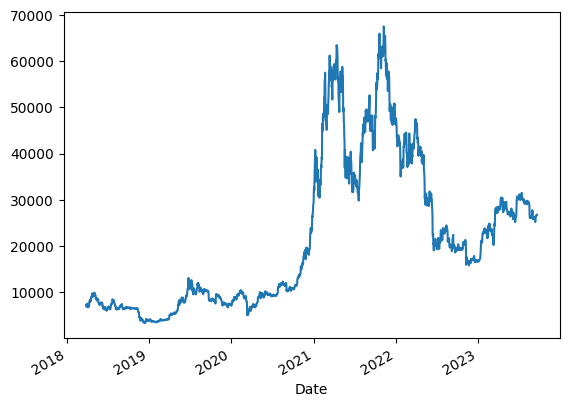

In [6]:
close.plot()

In [29]:
ret = close.pct_change()

<Axes: xlabel='Date'>

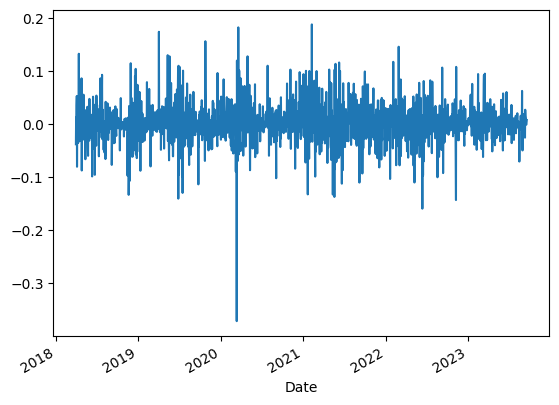

In [8]:
ret.plot()

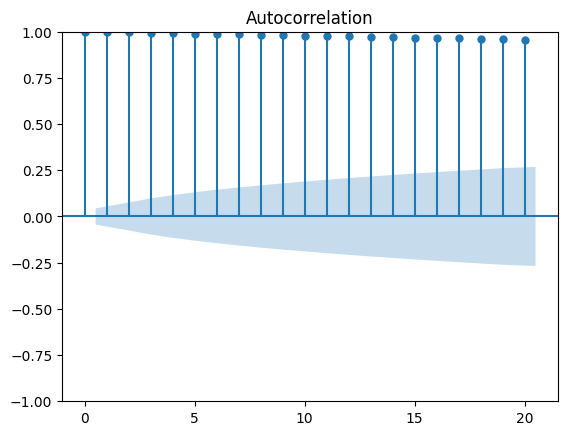

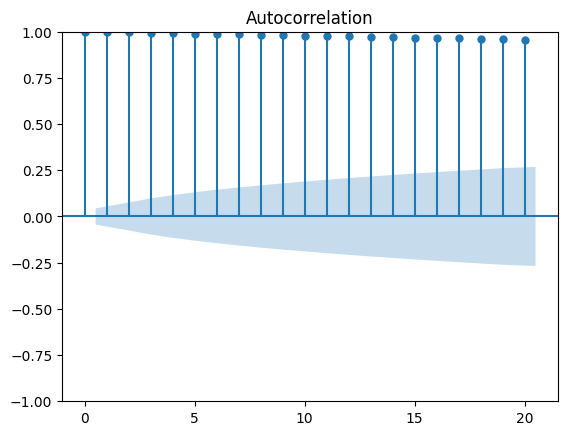

In [9]:
plot_acf(close, lags =20)


In [10]:
adftest=adfuller(close)
print('ADF Statistic: %f' % adftest[0])
print('ADF p-value: %f' % adftest[1])

ADF Statistic: -1.499123
ADF p-value: 0.533945


In [11]:
def get_mlp_data(time_series):
  ts_data = pd.DataFrame()
  lags = 30
  ts_data['t']=time_series
  for l in range(1,lags+1) :
    ts_data[f't_{l}'] = time_series.shift(l)

  X= ts_data.iloc[:,1:]
  y=ts_data['t_1']>ts_data[f't_{lags}']
  X=X[lags:]
  y=y[lags:]
  return X,y

In [12]:
def get_mlp_model():
  model = Sequential()
  model.add(Dense(100, activation ='relu'))
  model.add(Dense(1,activation = 'linear', name='output'))
  return model

# model = get_mlp_model()
# model.compile(optimizer='rmsprop', loss= 'categorical_crossentropy', metrics= ['accuracy'] )
# model.fit(X,y, batch_size =8, epochs =10)

In [13]:
def get_transofromed_images_labels(time_series ,window_size = 30):
  X_data = []
  for i in range(window_size, time_series.shape[0]):
      X_data.append(time_series[i - window_size : i])
  X_data = np.array(X_data)
  transformer = GramianAngularField()
  X_data_new = transformer.transform(X_data)
  y_data = []
  for i in range(0, time_series.shape[0] - window_size):
      y_data.append(time_series[i] < time_series[i + window_size])
  y_data = np.array(y_data)
  return X_data, X_data_new , y_data,

In [14]:
orig_data , transformed_imgs, y_labels = get_transofromed_images_labels(close)

In [16]:
# # Show the results for the first time series
# fig, ax = plt.subplots(1, 2, figsize=(10, 7), gridspec_kw={"width_ratios": [1, 1]})
# ax[0].plot(orig_data[0, :])
# ax[1].imshow(transformed_imgs[0], cmap="rainbow",label =y[0])
# plt.legend()

In [17]:
def get_cnn_model():
  model = Sequential()
  model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(30, 30, 1)))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(64, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(64, (3, 3), activation='relu'))
  model.add(layers.Flatten())
  model.add(layers.Dense(64, activation='relu'))
  model.add(layers.Dense(1))
  return model

In [18]:
# model = get_cnn_model()
# orig_data , transformed_imgs, y_labels = get_transofromed_images_labels(close)
# model.compile(loss="binary_crossentropy", optimizer="RMSprop", metrics=["accuracy"])

# history = model.fit(transformed_imgs, y_labels, epochs=10,  )

In [19]:
def get_lstm_model( ip_size=50,  n_features=1):
  SEED = 1234
  units_lstm = 50
  n_dropout = 0.2
  act_fun = "relu"
  model = tf.keras.models.Sequential( )
  model.add(tf.keras.layers.LSTM(units=units_lstm,return_sequences=True,activation="tanh",input_shape=(ip_size, n_features),))
  model.add(tf.keras.layers.LSTM(units=units_lstm, return_sequences=True, activation="tanh"))
  model.add(tf.keras.layers.Dropout(n_dropout, seed=SEED))


  model.add(tf.keras.layers.LSTM(units=units_lstm, return_sequences=True, activation="tanh"))
  model.add(tf.keras.layers.Dropout(n_dropout, seed=SEED))


  model.add(tf.keras.layers.LSTM(units=units_lstm, return_sequences=False, activation="tanh"))
  model.add(tf.keras.layers.Dropout(n_dropout, seed=SEED))

  model.add(tf.keras.layers.Dense(units=20, activation=act_fun))
  model.add(tf.keras.layers.Dropout(n_dropout, seed=SEED))

  model.add(tf.keras.layers.Dense(units=10, activation=act_fun))
  model.add(tf.keras.layers.Dropout(n_dropout, seed=SEED))

  model.add(tf.keras.layers.Dense(1))
  return model

In [20]:
def run_model(model, X_train, y_train):
  hp_lr = 1e-4
  model.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate=hp_lr), loss="mean_absolute_error"
  )
  es = EarlyStopping(
      monitor="val_loss", mode="min", verbose=1, patience=10, restore_best_weights=True
  )
  # fit the models
  model.fit(
      X_train,
      y_train,
      validation_split=0.2,
      epochs=50,
      batch_size=64,
      callbacks=[es],verbose=0
  )

In [21]:
close

Date
2018-03-29     7165.700195
2018-03-30     6890.520020
2018-03-31     6973.529785
2018-04-01     6844.229980
2018-04-02     7083.799805
                  ...     
2023-09-14    26539.673828
2023-09-15    26608.693359
2023-09-16    26568.281250
2023-09-17    26534.187500
2023-09-19    26730.207031
Name: Close, Length: 2000, dtype: float64

In [22]:
#ret.iloc[i + (n_train) : i + n_train + n_test].values

In [36]:
len(ret.index),len(set(ret.index))

(2000, 2000)

In [59]:
df= pd.DataFrame(index = ret.index)
df['Date'] = ret.index

In [60]:
df['Ret'] = ret

n_lags = 24 * 15

for i in range(1, n_lags + 1):
    name = "Ret_" + str(i)
    df[name] = df["Ret"].shift(i)

df["Ret4_i"] = df["Ret"].rolling(4).apply(lambda x: 100 * (np.prod(1 + x / 100) - 1))
df["Ret4"] = df["Ret4_i"].shift(-4)
df["Output"] = df["Ret4"] > 0
df["Output"] = df["Output"].astype(int)
del df["Ret4"]
del df["Ret4_i"]

df = df.dropna()

<ipython-input-60-c7e39cc15539>:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name] = df["Ret"].shift(i)
<ipython-input-60-c7e39cc15539>:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name] = df["Ret"].shift(i)
<ipython-input-60-c7e39cc15539>:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`


In [62]:
X, y = df.iloc[:, 2:-1], df.iloc[:, -1]
print(X.shape, y.shape)

(1639, 360) (1639,)


In [63]:
X

,Ret_1,Ret_2,Ret_3,Ret_4,Ret_5,Ret_6,Ret_7,Ret_8,Ret_9,Ret_10,...,Ret_351,Ret_352,Ret_353,Ret_354,Ret_355,Ret_356,Ret_357,Ret_358,Ret_359,Ret_360
Date,,,,,,,,,,,,,,,,,,,,,
2019-03-25,-0.003384,0.002947,-0.001330,-0.014226,0.004000,0.009593,0.001808,-0.005804,0.022170,0.009312,...,0.016268,0.041404,-0.025714,-0.006182,-0.080775,0.052558,0.035003,-0.018542,0.012047,-0.038402
2019-03-26,-0.014693,-0.003384,0.002947,-0.001330,-0.014226,0.004000,0.009593,0.001808,-0.005804,0.022170,...,-0.035992,0.016268,0.041404,-0.025714,-0.006182,-0.080775,0.052558,0.035003,-0.018542,0.012047
2019-03-27,0.005554,-0.014693,-0.003384,0.002947,-0.001330,-0.014226,0.004000,0.009593,0.001808,-0.005804,...,0.009457,-0.035992,0.016268,0.041404,-0.025714,-0.006182,-0.080775,0.052558,0.035003,-0.018542
2019-03-28,0.025592,0.005554,-0.014693,-0.003384,0.002947,-0.001330,-0.014226,0.004000,0.009593,0.001808,...,0.019541,0.009457,-0.035992,0.016268,0.041404,-0.025714,-0.006182,-0.080775,0.052558,0.035003
2019-03-29,-0.004394,0.025592,0.005554,-0.014693,-0.003384,0.002947,-0.001330,-0.014226,0.004000,0.009593,...,0.132160,0.019541,0.009457,-0.035992,0.016268,0.041404,-0.025714,-0.006182,-0.080775,0.052558
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-14,0.015290,0.026654,-0.025920,-0.002450,-0.000385,-0.012749,0.018909,-0.001037,-0.001257,-0.006051,...,0.016544,-0.005833,0.022368,-0.007124,-0.018688,-0.005971,0.046699,-0.018178,-0.033429,0.006417
2023-09-15,0.011871,0.015290,0.026654,-0.025920,-0.002450,-0.000385,-0.012749,0.018909,-0.001037,-0.001257,...,0.007532,0.016544,-0.005833,0.022368,-0.007124,-0.018688,-0.005971,0.046699,-0.018178,-0.033429
2023-09-16,0.002601,0.011871,0.015290,0.026654,-0.025920,-0.002450,-0.000385,-0.012749,0.018909,-0.001037,...,-0.007217,0.007532,0.016544,-0.005833,0.022368,-0.007124,-0.018688,-0.005971,0.046699,-0.018178


### MLP

In [71]:
X= X[-2000:]
y= y[-2000:]
hp_units = 85
hp_units_2 = 55
hp_units_3 = 30
n_dropout = 0.2
act_fun = "relu"
print(X.shape, y.shape)

n_train = 500
n_test = 100

time_backtest = []
time_backtest = np.array(time_backtest)
time_backtest = time_backtest.astype("datetime64", copy=False)

pred_backtest = []
ret_backtest = []

for i in range(0, len(y) - n_train, n_test):
    X_train, X_test = X[i : i + (n_train)], X[i + n_train : i + n_train + n_test]
    y_train, y_test = y[i : i + (n_train)], y[i + n_train : i + n_train + n_test]
    test_time = df.iloc[i + (n_train) : i + n_train + n_test, 0:1].values
    Ret_vector = df.iloc[i + (n_train) : i + n_train + n_test, 1:2].values
    print(
        "ite ",
        i / n_test,
        " -- start test:",
        test_time[0],
        " -- end test",
        test_time[-1],
        " ------- ",
        X_train.shape,
        y_train.shape,
        X_test.shape,
        y_test.shape,
        test_time.shape,
        Ret_vector.shape,
    )

    tf.keras.backend.clear_session()
    tf.random.set_seed(1234)

    # model = tf.keras.models.Sequential()
    # model.add(tf.keras.layers.Dense(units=hp_units, activation=act_fun))
    # model.add(tf.keras.layers.Dropout(n_dropout))
    # model.add(tf.keras.layers.Dense(units=hp_units_2, activation=act_fun))
    # model.add(tf.keras.layers.Dropout(n_dropout))
    # model.add(tf.keras.layers.Dense(units=hp_units_3, activation=act_fun))
    # model.add(tf.keras.layers.Dropout(n_dropout))
    # model.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

    model = get_mlp_model()

    hp_lr = 1e-5

    adam = tf.keras.optimizers.Adam(learning_rate=hp_lr)
    model.compile(optimizer=adam, loss="binary_crossentropy", metrics=["accuracy"])

    es = tf.keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        mode="max",
        verbose=0,
        patience=20,
        restore_best_weights=True,
    )
    class_weight = {0: (np.mean(y_train) / 0.5), 1: 1}
    history = model.fit(
        X_train,
        y_train,
        validation_split=0.15,
        epochs=500,
        batch_size=32,
        verbose=0,
        callbacks=[es],
        class_weight=class_weight,
    )

    y_prob = model.predict(X_test, verbose=0)
    y_pred = np.where(y_prob > 0.50, 1, 0)

    time_backtest = np.append(time_backtest, test_time.flatten())
    pred_backtest = np.append(pred_backtest, y_pred.flatten())
    ret_backtest = np.append(ret_backtest, Ret_vector.flatten())

df_predictions = pd.DataFrame(
    {"Date": time_backtest, "Pred": pred_backtest, "Ret": ret_backtest}
)



(1639, 360) (1639,)
ite  0.0  -- start test: ['2020-08-06T00:00:00.000000000']  -- end test ['2020-11-13T00:00:00.000000000']  -------  (500, 360) (500,) (100, 360) (100,) (100, 1) (100, 1)
ite  1.0  -- start test: ['2020-11-14T00:00:00.000000000']  -- end test ['2021-02-21T00:00:00.000000000']  -------  (500, 360) (500,) (100, 360) (100,) (100, 1) (100, 1)
ite  2.0  -- start test: ['2021-02-22T00:00:00.000000000']  -- end test ['2021-06-01T00:00:00.000000000']  -------  (500, 360) (500,) (100, 360) (100,) (100, 1) (100, 1)
ite  3.0  -- start test: ['2021-06-02T00:00:00.000000000']  -- end test ['2021-09-09T00:00:00.000000000']  -------  (500, 360) (500,) (100, 360) (100,) (100, 1) (100, 1)
ite  4.0  -- start test: ['2021-09-10T00:00:00.000000000']  -- end test ['2021-12-18T00:00:00.000000000']  -------  (500, 360) (500,) (100, 360) (100,) (100, 1) (100, 1)
ite  5.0  -- start test: ['2021-12-19T00:00:00.000000000']  -- end test ['2022-03-28T00:00:00.000000000']  -------  (500, 360) (50

In [66]:
ret_backtest.shape

(1139,)

In [67]:
df_predictions.Date = pd.to_datetime(df_predictions.Date, format="%YYYY-%mm-%dd")
df_res = df_predictions
df_res.tail()

,Date,Pred,Ret
1134,2023-09-14,0.0,0.011871
1135,2023-09-15,0.0,0.002601
1136,2023-09-16,1.0,-0.001519
1137,2023-09-17,0.0,-0.001283
1138,2023-09-19,0.0,0.007387


In [68]:
df_res["Positions"] = np.where(df_res["Pred"] > 0.5, 1, -1)
df_res["Positions_shift"] = df_res["Positions"].shift(1)
df_res["Strat_ret"] = df_res["Positions"].shift(1) * df_res["Ret"]
df_res["Positions_L"] = df_res["Positions"].shift(1)
df_res["Positions_L"][df_res["Positions_L"] == -1] = 0
df_res["Strat_ret_L"] = df_res["Positions_L"] * df_res["Ret"]
df_res["CumRet"] = df_res["Strat_ret"].expanding().apply(lambda x: np.prod(1 + x) - 1)
df_res["CumRet_L"] = (
    df_res["Strat_ret_L"].expanding().apply(lambda x: np.prod(1 + x) - 1)
)
df_res["bhRet"] = df_res["Ret"].expanding().apply(lambda x: np.prod(1 + x) - 1)

Final_Return_L = np.prod(1 + df_res["Strat_ret_L"]) - 1
Final_Return = np.prod(1 + df_res["Strat_ret"]) - 1
Buy_Return = np.prod(1 + df_res["Ret"]) - 1

print("Strat Return Long Only =", Final_Return_L * 100, "%")
print("Strat Return =", Final_Return * 100, "%")
print("Buy and Hold Return =", Buy_Return * 100, "%")

<ipython-input-68-63b3cfa1bcb3>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_res["Positions_L"][df_res["Positions_L"] == -1] = 0


Strat Return Long Only = 39.17988273795841 %
Strat Return = -49.03244200202293 %
Buy and Hold Return = 127.54878625742228 %


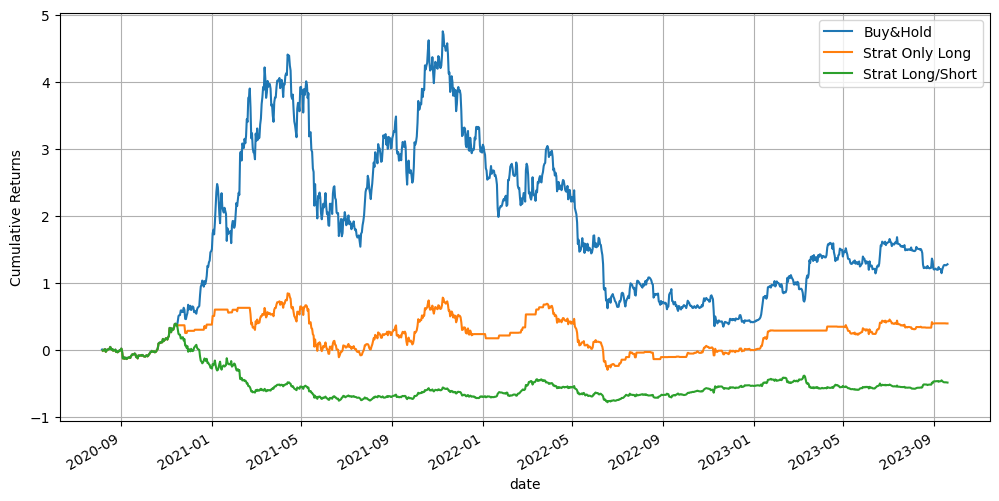

,Pred,Ret,Positions,Positions_shift,Strat_ret,Positions_L,Strat_ret_L,CumRet,CumRet_L,bhRet,trade_bin
count,1139.000000,1139.000000,1139.000000,1138.000000,1138.000000,1138.000000,1138.000000,1138.000000,1138.000000,1139.000000,1138.000000
mean,0.594381,0.001301,0.188762,0.189807,-0.000006,0.594903,0.000647,-0.514808,0.234622,1.739516,0.206503
std,0.491227,0.034036,0.982454,0.982253,0.034076,0.491127,0.026625,0.231441,0.242375,1.193973,0.404973
min,0.000000,-0.159747,-1.000000,-1.000000,-0.187465,0.000000,-0.159747,-0.783963,-0.300216,-0.137525,0.000000
25%,0.000000,-0.014433,-1.000000,-1.000000,-0.014603,0.000000,-0.002514,-0.673881,0.008354,0.756531,0.000000
50%,1.000000,0.000189,1.000000,1.000000,0.000992,1.000000,-0.000000,-0.573178,0.258546,1.497676,0.000000
75%,1.000000,0.016610,1.000000,1.000000,0.016000,1.000000,0.004856,-0.487885,0.392203,2.610292,0.000000
max,1.000000,0.187465,1.000000,1.000000,0.145412,1.000000,0.145412,0.386354,0.841645,4.751826,1.000000


In [70]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12, 6))
ax = plt.gca()
df_res.plot(x="Date", y="bhRet", label="Buy&Hold", ax=ax)
df_res.plot(x="Date", y="CumRet_L", label="Strat Only Long", ax=ax)
df_res.plot(x="Date", y="CumRet", label="Strat Long/Short", ax=ax)
plt.xlabel("date")
plt.ylabel("Cumulative Returns")
plt.grid()
plt.show()

df_res["trade_bin"] = df_res["Positions"].diff().abs()
df_res["trade_bin"] = df_res["trade_bin"] / 2
df_res.describe()

### CNN

In [ ]:
hp_units = 85
hp_units_2 = 55
hp_units_3 = 30
n_dropout = 0.2
act_fun = "relu"
print(X.shape, y.shape)

n_train = 500
n_test = 100

time_backtest = []
time_backtest = np.array(time_backtest)
time_backtest = time_backtest.astype("datetime64", copy=False)

pred_backtest = []
ret_backtest = []

for i in range(0, len(y) - n_train, n_test):
    X_train, X_test = X[i : i + (n_train)], X[i + n_train : i + n_train + n_test]
    y_train, y_test = y[i : i + (n_train)], y[i + n_train : i + n_train + n_test]
    test_time = df.iloc[i + (n_train) : i + n_train + n_test, 0:1].values
    Ret_vector = df.iloc[i + (n_train) : i + n_train + n_test, 1:2].values
    print(
        "ite ",
        i / n_test,
        " -- start test:",
        test_time[0],
        " -- end test",
        test_time[-1],
        " ------- ",
        X_train.shape,
        y_train.shape,
        X_test.shape,
        y_test.shape,
        test_time.shape,
        Ret_vector.shape,
    )

    tf.keras.backend.clear_session()
    tf.random.set_seed(1234)

    # model = tf.keras.models.Sequential()
    # model.add(tf.keras.layers.Dense(units=hp_units, activation=act_fun))
    # model.add(tf.keras.layers.Dropout(n_dropout))
    # model.add(tf.keras.layers.Dense(units=hp_units_2, activation=act_fun))
    # model.add(tf.keras.layers.Dropout(n_dropout))
    # model.add(tf.keras.layers.Dense(units=hp_units_3, activation=act_fun))
    # model.add(tf.keras.layers.Dropout(n_dropout))
    # model.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

    model = get_mlp_model()

    hp_lr = 1e-5

    adam = tf.keras.optimizers.Adam(learning_rate=hp_lr)
    model.compile(optimizer=adam, loss="binary_crossentropy", metrics=["accuracy"])

    es = tf.keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        mode="max",
        verbose=0,
        patience=20,
        restore_best_weights=True,
    )
    class_weight = {0: (np.mean(y_train) / 0.5), 1: 1}
    history = model.fit(
        X_train,
        y_train,
        validation_split=0.15,
        epochs=500,
        batch_size=32,
        verbose=0,
        callbacks=[es],
        class_weight=class_weight,
    )

    y_prob = model.predict(X_test, verbose=0)
    y_pred = np.where(y_prob > 0.50, 1, 0)

    time_backtest = np.append(time_backtest, test_time.flatten())
    pred_backtest = np.append(pred_backtest, y_pred.flatten())
    ret_backtest = np.append(ret_backtest, Ret_vector.flatten())

df_predictions = pd.DataFrame(
    {"Date": time_backtest, "Pred": pred_backtest, "Ret": ret_backtest}
)
